In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import numpy as np
import json
from scipy import stats
import plotly
from plotly.graph_objs import Scatter, Layout

In [18]:
df = pd.read_csv('2008.csv') #Carga el CSV entero
#df # df por data frame es la estructura de datos que representa tablas en pandas https://pandas.pydata.org/pandas-docs/stable/dsintro.html

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [4]:
#df[df.WeatherDelay > 0].groupby('OriginCity').Origin.count().sort_values(ascending=False)# Los Aeropuertos con mas delays por mal tiempo
#-
#df[df.WeatherDelay > 0].groupby('Dest').Dest.count().sort_values(ascending=False)# Los Aeropuertos con mas delays por mal tiempo#
#-
#df['Trip'] = df['Origin'] + "->" + df['Dest'] 
#df[df.WeatherDelay > 0].groupby('Trip').Trip.count().sort_values(ascending=False)
#-
#df[df.WeatherDelay > 0].groupby('Month').Month.count()
#df.plot()
#plt.show()
#-

# Por mes

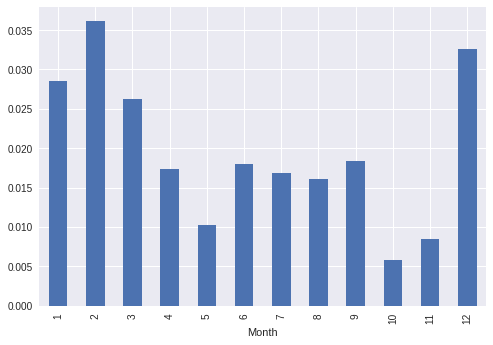

In [31]:
(df[df.Cancelled > 0].groupby('Month').Month.count() / df.groupby('Month').Month.count()).plot.bar()

plt.show()

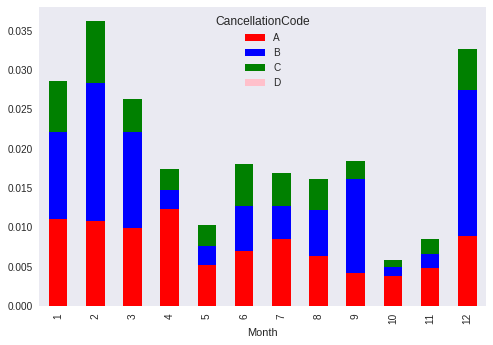

In [54]:
def plotCancellationCodesBy(df, index):  
    # (A = carrier, B = weather, C = NAS, D = security)
    var = df[df.Cancelled > 0].groupby([index,'CancellationCode'])[index].count() / df.groupby([index])[index].count()
    var.unstack().plot(kind='bar',stacked=True, color=['red','blue','green','pink'], grid=False)
    plt.show()
plotCancellationCodesBy(df, 'Month')

# Por Dia

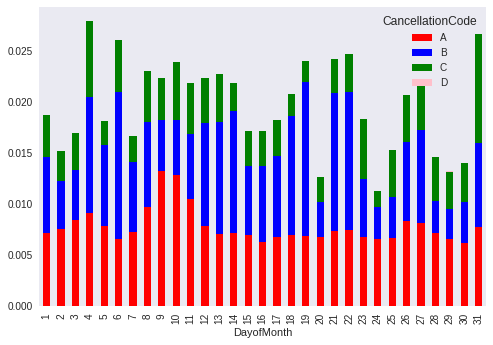

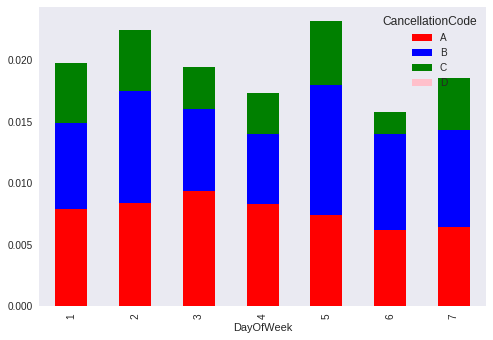

In [107]:
plotCancellationCodesBy(df, 'DayofMonth')
plotCancellationCodesBy(df, 'DayOfWeek')

# Por distancia

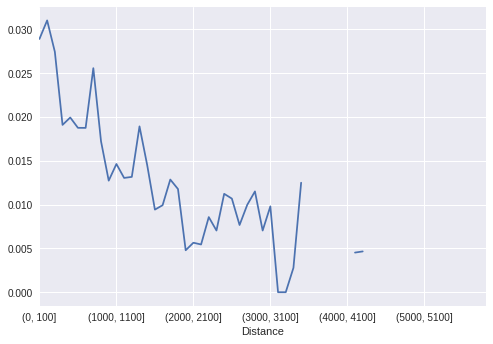

In [108]:
index = 'Distance'
ranges = np.arange(0,6000,100)
var = df[df.Cancelled > 0].groupby(pd.cut(df[df.Cancelled > 0].Distance, ranges))[index].count() / df.groupby(pd.cut(df.Distance, ranges))[index].count()
var.plot(kind='line')
plt.show()

# Heatmap


In [61]:
#with open('airportCodeToCityCode.json') as data_file:    
#    airportToCity = json.load(data_file)
def addState(airports, df, code, to):
    for i, row in df.iterrows():
        if airports[airports["Code"] == row[code]].size > 0:
            df.loc[i, to] = airports[airports["Code"] == row[code]].iloc[0].State
    return df
def heatmap(var, statecode, zcode, filename):
    scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

    #HEATMAP
    data = [ dict(
            type='choropleth',
            colorscale = scl,
            autocolorscale = False,
            locations = var[statecode],
            z = var[zcode].astype(float),
            locationmode = 'USA-states',
            marker = dict(
                line = dict (
                    color = 'rgb(255,255,255)',
                    width = 2
                )
            ),
            colorbar = dict(
                title = "Cantidad de Vuelos Demorados en 2008 por mal clima"
            )
        ) ]

    layout = dict(
            title = '2011 US Agriculture Exports by State<br>(Hover for breakdown)',
            geo = dict(
                scope='usa',
                projection=dict( type='albers usa' ),
                showlakes = True,
                lakecolor = 'rgb(255, 255, 255)',
            ),
        )

    fig = dict(data=data, layout=layout)

    url = plotly.offline.plot(fig, filename=filename)


In [62]:
airports = pd.read_csv('airports.csv') 
malClimaSeries = df[df.WeatherDelay > 0].groupby('Origin').Origin.count().sort_values(ascending=False)
malClimaDF = pd.DataFrame({'Origin':malClimaSeries.index, 'Count':malClimaSeries.values})
malClimaDF = addState(airports, malClimaDF, 'Origin', 'OriginState')
var = malClimaDF[malClimaDF.OriginState.notnull()].groupby('OriginState').sum().reset_index()
heatmap(var, 'OriginState', 'Count', 'origen2008.html') 

malClimaSeries = df[df.WeatherDelay > 0].groupby('Dest').Dest.count().sort_values(ascending=False)
malClimaDF = pd.DataFrame({'Dest':malClimaSeries.index, 'Count':malClimaSeries.values})
malClimaDF = addState(airports, malClimaDF, 'Dest', 'DestState')
var = malClimaDF[malClimaDF.DestState.notnull()].groupby('DestState').sum().reset_index()
heatmap(var, 'DestState', 'Count', 'dest2008.html')


malClimaSeries = df[df.Cancelled > 0].groupby('Origin').Origin.count().sort_values(ascending=False)
malClimaDF = pd.DataFrame({'Origin':malClimaSeries.index, 'Count':malClimaSeries.values})
malClimaDF = addState(airports, malClimaDF, 'Origin', 'OriginState')
var = malClimaDF[malClimaDF.OriginState.notnull()].groupby('OriginState').sum().reset_index()
heatmap(var, 'OriginState', 'Count', 'Cancelledorigen2008.html') 

malClimaSeries = df[df.Cancelled > 0].groupby('Dest').Dest.count().sort_values(ascending=False)
malClimaDF = pd.DataFrame({'Dest':malClimaSeries.index, 'Count':malClimaSeries.values})
malClimaDF = addState(airports, malClimaDF, 'Dest', 'DestState')
var = malClimaDF[malClimaDF.DestState.notnull()].groupby('DestState').sum().reset_index()
heatmap(var, 'DestState', 'Count', 'Cancelleddest2008.html')
#var = malClimaDF[malClimaDF.OriginState.isnull()]

In [33]:
df[df.Cancelled > 0].Cancelled

178        1
373        1
399        1
401        1
415        1
676        1
686        1
727        1
881        1
884        1
974        1
977        1
1015       1
1016       1
1044       1
1074       1
1080       1
1099       1
1163       1
1400       1
1707       1
1713       1
1715       1
1730       1
1779       1
1796       1
1902       1
1903       1
1915       1
1916       1
          ..
7008067    1
7008240    1
7008247    1
7008351    1
7008531    1
7008561    1
7008562    1
7008584    1
7008586    1
7008589    1
7008590    1
7008591    1
7008593    1
7008594    1
7008597    1
7008632    1
7008721    1
7008727    1
7008813    1
7008869    1
7008900    1
7008940    1
7009381    1
7009396    1
7009397    1
7009455    1
7009464    1
7009564    1
7009565    1
7009648    1
Name: Cancelled, dtype: int64

/usr/local/lib/python3.5/dist-packages/plotly/offline/offline.py:459: UserWarning:

Your filename `d3-cloropleth-map` didn't end with .html. Adding .html to the end of your file.

